# Fragment-based drug discovery tutorial
## Introduction

To illustrate some parts of the fragment-based drug discovery (FBDD) pipeline, we will focus on the SARS-COV-2 target non-structural protein 13 (nsp13). One of sixteen non-structural proteins, this family are involved in replication and transcription of the virus, and nsp13 has been shown to be critical for replication in related SARS-CoV species, thus representing an attractive target for the development of antiviral drugs. 

In this practical, we will look at a set of 9 fragment hits found to bind to the nsp13 active site. If you wish to view the crystal structure for this target, you can do so in Fragalysis at the following link (https://fragalysis.diamond.ac.uk/viewer/react/preview/target/nsp13).

![Fragalysis screenshot](imgs/fragalysis_screenshot.png)

In the 'Hit navigator' section on the left-hand side of the screen you can scroll through the fragment hits. Select the 'L' button for each ligand to display the ligand, and 'P' to display the side chains for that crystal structure. 

## Imports

First, we'll import the libraries the packages that we'll be using for this tutorial

In [195]:
import os
import mols2grid
import numpy as np
import py3Dmol
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdmolfiles, PyMol, Crippen, Descriptors, rdMolDescriptors, rdShapeHelpers
from rdkit.Chem.FeatMaps import FeatMaps
from rdkit import RDConfig
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.FilterCatalog import *

IPythonConsole.ipython_3d = True

## Fragments

Next, we'll load a set of fragment hits against nsp13. These are saved in an sdf file, meaning 'structure-data file', a file format that contains information regarding the coordinates of individual atoms. The molecules can be assigned properties in sdf file; in this file, the name of the fragment has been assigned. XChem fragments are named according to a number, followed by a letter designating the protein chain, e.g. x0034_0B.

In [148]:
# Load the fragments using the function rdkit.Chem.SDMolSupplier()

sdf = 'data/nsp13_mols.sdf'
fragments = Chem.SDMolSupplier(sdf)

# We can view the fragments using 'mols2grid', an interactive molecule viewer for 2D structures
mols2grid.display(sdf, subset=['img', 'fragment'])

/home/swills/app/miniconda3/envs/fbdd_demo/lib/python3.7/site-packages/mols2grid/select.py:26: UserWarning: Overwriting non-empty 'default' grid selection: {0: 'Cc1ccc(CS(N)(=O)=O)cc1F', 1: 'CS(=O)(=O)NCCc1ccccc1', 2: 'C[C@H](CS(N)(=O)=O)c1ccccc1'}
  f"Overwriting non-empty {name!r} grid selection: {str(overwrite)}"


If you would like to view the 3D conformations of the bound fragments, use the tick boxes on the fragments above
and run the cells below. This cell uses py3Dmol, which allows molecular visualization in iPython notebooks.

For more information on these tools, see the relevant Blopig links:
- **mols2grid**: https://www.blopig.com/blog/2021/10/how-to-interact-with-small-molecules-in-jupyter-notebooks/
- **py3Dmol**: https://www.blopig.com/blog/2016/10/viewing-3d-molecules-interactively-in-jupyter-ipython-notebooks/

In [149]:
def Draw3DMols(mols, size=(300, 300), style='stick', protein=False):
    """
    Draws selected molecules in 3D
    
    Args:
    ----
        mols: list of rdkit molecules
        size: tuple(int, int), canvas size
        style: str, type of drawing molecule, style can be 'line', 'stick', 'sphere', 'cross'
    Return:
    ----
        viewer: py3Dmol.view, a class for constructing embedded 3Dmol.js views in ipython notebooks.
    """
    viewer = py3Dmol.view(width=size[0], height=size[1])
    for mol in mols:
        mblock = Chem.MolToMolBlock(mol)
        viewer.addModel(mblock, 'mol')
    viewer.setStyle({style:{'colorscheme': 'cyanCarbon'}})
    if protein:
        viewer.addModel(open('data/nsp13_apo-desolv.pdb', 'r').read(), 'pdb')
        viewer.setStyle({'chain':'B'},{'line': {'color':'white'}})
        viewer.addSurface(py3Dmol.VDW,{'opacity': 0.7, 'color': 'white'})
        
    viewer.zoomTo()
    return viewer.show()

In [150]:
selected_fragments = [fragments[i] for i in mols2grid.get_selection().keys()]
Draw3DMols(selected_fragments)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [151]:
# You can also use py3Dmol to view where the fragments are in relation to the protein
Draw3DMols(selected_fragments, size=(500,500), protein=True)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Generate some elaborations

Next, we will look at some example elaborations for these fragments. 

### Fragment growing and linking
To do this we will use a piece of software called CReM (Chemically Reasonable Mutations), inspired by a blogpost by Pat Walters on Practical Cheminformatics.

**Links**:
- **Blogpost**: http://practicalcheminformatics.blogspot.com/2020/03/building-on-fragments-from-diamondxchem.html
- **CrEM paper**: https://jcheminf.biomedcentral.com/articles/10.1186/s13321-020-00431-w
- **GitHub repo**: https://github.com/DrrDom/crem

In short, CReM is based on matched molecular pairs, referring to a pair of molecules that differ by a chemical transformation at a single site. CrEM involves the generation of a database of interchangeable fragments from a set of input molecules, whereby fragments that share a similar chemical context can be replaced to generate new molecules (exemplified by the diagram below). The chemical context is defined by a user-specified radius.

![CREM figure 1](imgs/crem_f1.png)

Therefore, we can attach or replace certain functional groups by checking they share the same chemical context around the attachment point. CrEM allows three types of transformation.

- **MUTATE**: replacement of a fragment
- **GROW**: replacement of a hydrogen with another fragment
- **LINK**: replacement of hydrogen atoms in two fragments with a fragment, thus linking the compounds together 

![CREM figure 3](imgs/crem_f3.png)

We will look at some of the molecules generated using the GROW and LINK transformations. A pre-generated database containing fragmented ChEMBL compounds was used. As the database is quite large, these elaborations have already been generated for you and can be retrieved using the code below.

Because I love mols2grid, select either the single molecule you want to grow or the two molecules you want to link.

In [152]:
mols2grid.display(sdf, subset=['img', 'fragment'])

/home/swills/app/miniconda3/envs/fbdd_demo/lib/python3.7/site-packages/mols2grid/select.py:26: UserWarning: Overwriting non-empty 'default' grid selection: {7: 'OC1CN(C(c2ccccc2)c2ccccc2)C1', 3: 'CC(=O)Nc1cc(C(=O)O)ccc1F', 4: 'Fc1ccccc1CNc1cn[nH]c1'}
  f"Overwriting non-empty {name!r} grid selection: {str(overwrite)}"


In [168]:
def get_elaborations(elab_type='grow', sdf='data/nsp13_mols.sdf'):
    """
    Run this function to retrieve the data. Specify whether you want to grow or link fragment(s).

    Args:
    ----
        elab_type: 'grow' or 'link'
    Return:
    ----
        elaborations: list of elaborated molecules 
    """
    mols = Chem.SDMolSupplier(sdf)
    names = [m.GetProp('fragment') for m in mols]
    frags = [names[i] for i in list(mols2grid.get_selection().keys())]
    if elab_type == 'grow':
        if len(frags) != 1:
            raise Exception("Please select only one fragment for growing.")
        else:
            file = os.path.join('data', 'grow_mols', f'{frags[0]}.sdf')
            suppl = Chem.SDMolSupplier(file)
    elif elab_type == 'link':
        if len(frags) != 2:
            raise Exception("Please select two fragments for linking.")
        else:
            frags.sort()
            file = os.path.join('data', 'link_mols', f'{frags[0]}-{frags[1]}.sdf')
            suppl = Chem.SDMolSupplier(file)
    else:
        raise Exception('Invalid elab type')
    
    elaborations = [m for m in suppl]
    print(f'{len(elaborations)} elaborated molecules found for that transformation.')
    return elaborations

Retrieve the data based on your selection and display the first 9 using rdkit.Chem.Draw.MolsToGridImage. Change the argument from 'grow' to 'link' to find linkers.

91 elaborated molecules found for that transformation.


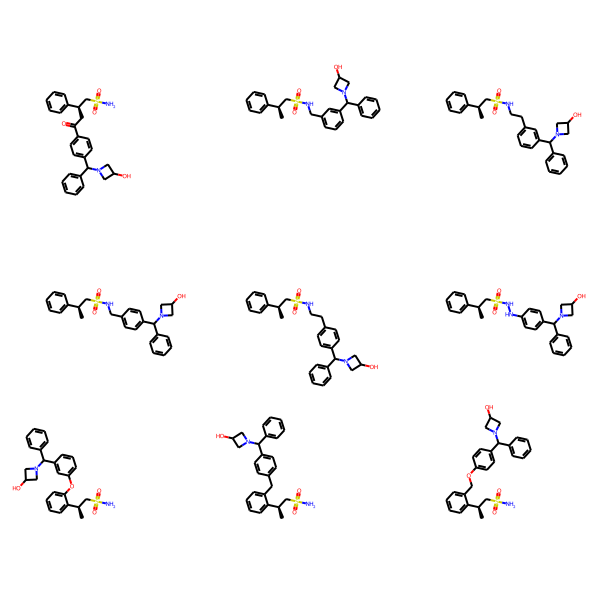

In [169]:
mols = get_elaborations('link')
Draw.MolsToGridImage(mols[:9], molsPerRow=3)

## Filtering fragments

Following enumeration of the elaborated compounds, we may want to apply filters to prioritise the most promising compounds and those that are most likely to retain the binding pose and interactions of the inspirational fragments. There are several ways we can do this, using both 2D and 3D filters.

We will start with two very simple 2D filtering steps, the first being Lipinski's rules (used to determine drug-likeness using calculated molecular descriptors such as molecular weight, number of hydrogen bond donors and acceptors, etc.; https://en.wikipedia.org/wiki/Lipinski%27s_rule_of_five).

### Lipinski filters

In [155]:
def lipinski_filter(mols):
    """
    Filters molecules that violate Lipinski's ro5.
    
    Args:
    ----
        mols: RDKit molecules to filter
    Return:
    ----
        filtered_mols
    """
    filtered_mols = []
    for mol in mols:
        molwt = Descriptors.MolWt(mol)
        logp = Crippen.MolLogP(mol)
        HBA = Chem.rdMolDescriptors.CalcNumHBA(mol)
        HBD = Chem.rdMolDescriptors.CalcNumHBD(mol)

        violations = 0

        if molwt>500:
            violations += 1
        if logp > 5:
            violations += 1
        if HBA > 10:
            violations += 1
        if HBD > 5:
            violations += 1

        if violations < 2:
            filtered_mols.append(mol)
    print(f"{len(filtered_mols)}/{len(mols)} molecules remaining after filtering")
    return filtered_mols

In [170]:
mols = lipinski_filter(mols)

91/91 molecules remaining after filtering


### PAINS compounds
Pan-assay interference (PAINS) compounds are compounds that contain reactive groups that are likely to cause false-positive results in assays, and thus it is often favourable to remove these compounds. We can do this using RDKit's filter catalog.

In [157]:
def pains_filter(mols):
    """
    Filters undesirable PAINS compounds using RDKit's filter catalog.
    
    Args:
    ----
        mols: RDKit molecules to filter
    Return:
    ----
        filtered_mols
    """
    filtered_mols = []
    params = FilterCatalogParams()
    params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS_A)
    params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS_B)
    params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS_C)
    catalog = FilterCatalog(params)
    for mol in mols:
        if not catalog.HasMatch(mol):
            filtered_mols.append(mol)
    print(f"{len(filtered_mols)}/{len(mols)} molecules remaining after filtering")
    return filtered_mols

In [171]:
mols = pains_filter(mols)

88/91 molecules remaining after filtering


## Generating 3D conformations
As already discussed in the talk, once we have enumerated these compounds, we then want to generate binding poses, which can be used to determine whether the compounds are able to retain the binding pose of the original fragments and determine their likelihood to bind and recapitulate the interactions made,

We will demonstrate conformer generation using two simple approaches.

### ETDKG and alignment

In the first approach, we will generate conformations for elaborated molecules using the ETKDG algorithm mentioned during the talk. The conformations are aligned to the parent fragment(s) and scored using the SuCOS metric. SuCOS is a scoring function that looks at the overlap between the shape and the pharmacophoric features of the elaborated ligand with the parent fragments. The conformer with the highest SuCOS score is then returned.

More information on SuCOS can be found at the following links:
- **Paper**: https://chemrxiv.org/engage/chemrxiv/article-details/60c741a99abda23230f8bed5
- **GitHub repo**: https://github.com/susanhleung/SuCOS
- **Normalized SuCOS blopig post**: https://www.blopig.com/blog/2021/11/using-normalized-sucos-scores/

*Code borrowed/adapted from an XChem practical at* https://github.com/xchem/strucbio_practical

In [189]:

########################################################################################
#
#  SuCOS Implementation
#
########################################################################################

fdef = AllChem.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef'))

fmParams = {}
for k in fdef.GetFeatureFamilies():
    fparams = FeatMaps.FeatMapParams()
    fmParams[k] = fparams

keep = ('Donor', 'Acceptor', 'NegIonizable', 'PosIonizable', 'ZnBinder',
        'Aromatic', 'Hydrophobe', 'LumpedHydrophobe')


def get_FeatureMapScore(small_m, large_m, score_mode=FeatMaps.FeatMapScoreMode.Best):
    featLists = []
    for m in [small_m, large_m]:
        rawFeats = fdef.GetFeaturesForMol(m)
        # filter that list down to only include the ones we're intereted in
        featLists.append([f for f in rawFeats if f.GetFamily() in keep])
    fms = [FeatMaps.FeatMap(feats=x, weights=[1] * len(x), params=fmParams) for x in featLists]
    fms[0].scoreMode = score_mode
    fm_score = fms[0].ScoreFeats(featLists[1]) / min(fms[0].GetNumFeatures(), len(featLists[1]))
    return fm_score


def score(reflig, prb_mols, ids, score_mode=FeatMaps.FeatMapScoreMode.All, p=False):
    ref = Chem.AddHs(reflig)
    idx = 0

    results_sucos = {}
    results_tani = {}

    smi_mol = Chem.MolToSmiles(prb_mols)

    for i in ids:

        prb = Chem.AddHs(Chem.MolFromMolBlock(Chem.MolToMolBlock(prb_mols, confId=i)))

        fm_score = get_FeatureMapScore(ref, prb, score_mode)
        fm_score = np.clip(fm_score, 0, 1)

        protrude_dist = rdShapeHelpers.ShapeProtrudeDist(ref, prb,
                                                         allowReordering=False)
        protrude_dist = np.clip(protrude_dist, 0, 1)

        SuCOS_score = 0.5 * fm_score + 0.5 * (1 - protrude_dist)
        tanimoto_score = Chem.rdShapeHelpers.ShapeTanimotoDist(ref, prb)

        results_sucos[str(idx)] = SuCOS_score
        results_tani[str(idx)] = tanimoto_score

        if p:
            print("********************************")
            print("index: " + str(idx))
            print("SuCOS score:\t%f" % SuCOS_score)
            print("Tani score:\t%f" % tanimoto_score)
            print("********************************")

        idx += 1

    return results_sucos


########################################################################################
#
#  Alignment & scoring implementation
#
########################################################################################

def get_best_align(fragment, elab_mol, numConfs=100):
    ids = AllChem.EmbedMultipleConfs(elab_mol, numConfs=numConfs, params=AllChem.ETKDG())

    for cid in ids:
        o3d = Chem.rdMolAlign.GetO3A(prbMol=elab_mol, refMol=fragment, prbCid=cid)
        o3d.Align()

    results_sucos = score(fragment, elab_mol, ids)
    best_i = list(results_sucos.values()).index(max(results_sucos.values()))
    elab_molblock = Chem.MolToMolBlock(elab_mol, confId=best_i)

    return elab_molblock

In [212]:
def gen_conf_from_vector(elab_mol):
    fragment_d = {}
    for f in fragments:
        name = f.GetProp('fragment')
        fragment_d[name] = f
    
    if elab_mol.HasProp('insp_fragment'):
        frag_name = elab_mol.GetProp('insp_fragment')
        ref_mol = fragment_d[frag_name]
        conf = Chem.MolFromMolBlock(get_best_align(ref_mol, elab_mol))
    
    elif elab_mol.HasProp('insp_fragments'):
        frag_names = elab_mol.GetProp('insp_fragments').split('-')
        frags = [fragment_d[f] for f in frag_names]
        ref_mol = Chem.rdmolops.CombineMols(frags[0], frags[1])
        conf = Chem.MolFromMolBlock(get_best_align(ref_mol, elab_mol))

    return conf, ref_mol

In [216]:
def display_aligned_mol(elab_mol, size=(300, 300), style='stick'):
    conf, ref_mol = gen_conf_from_vector(elab_mol)
    mblock = Chem.MolToMolBlock(conf)
    viewer = py3Dmol.view(width=size[0], height=size[1])
    viewer.addModel(mblock, 'mol')
    refblock = Chem.MolToMolBlock(ref_mol)
    viewer.addModel(refblock, 'mol')
    viewer.setStyle({style:{'colorscheme': 'cyanCarbon'}})
    viewer.zoomTo()
    return viewer.show()
    
display_aligned_mol(mols[0])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Constrained embedding
We can use constrained embedding to generate conformations for molecules whereby we constrain the positions of the atoms that came from the inspirational fragments using their original 3D cooordinates. This function performs better for growth elaborations than for example merges, as it may not be possible to generate a physically reasonable structure constrained with the parent fragments' coordinates.

More information can be found on the constrained embed function at the following links:
- **RDKit blog**: Using AllChem.ConstrainedEmbed: http://rdkit.blogspot.com/2013/12/using-allchemconstrainedembed.html
- **RDKit blog**: More on constrained embedding: http://rdkit.blogspot.com/2019/01/more-on-constrained-embedding.html
- **Blopig**: Constrained Embedding with RDKit: https://www.blopig.com/blog/2019/06/constrained-embedding-with-rdkit/

# Scoring

### RMSD

### SuCOS

### Shape Tanimoto